<div style="background: linear-gradient(to right, #4b6cb7, #182848); padding: 20px; border-radius: 10px; text-align: center; box-shadow: 0 4px 6px rgba(0,0,0,0.1);">
    <h1 style="color: white; margin: 0; font-size: 2.5em; font-weight: 700;">GAICo: GenAI Results Comparator</h1>
    <p style="color: #e0e0e0; margin-top: 10px; font-style: italic; font-size: 1.2em; text-align: center;">Workflow Tutorial</p>
</div>
<br>

Welcome to the <b>GAICo</b> library! This notebook will guide you through its features and demonstrate how to use it for evaluating text generated by Large Language Models (LLMs) against reference texts.

This example is designed for technical users who want to:

- Compare generated text strings with ground truth versions.
- Utilize a range of reference-based evaluation metrics.
- Process single pairs or batches of text efficiently.
- Apply thresholds to evaluation scores.
- Visualize comparison results.

### 1. Import Required Libraries

For this notebook, we'll assume the library is installed or made accessible via the path modification below.


In [1]:
import sys
import os

# Get the current working directory of the notebook
notebook_dir = os.getcwd()
# Construct the path to the project root (one level up)
project_root = os.path.abspath(os.path.join(notebook_dir, os.pardir))

# Add project root to the system path if it's not already there
if project_root not in sys.path:
    sys.path.insert(0, project_root)

Now, that the `gaico` package is confirmed importable, let's continue by importing necessary modules from the library and other common packages.


In [2]:
from pprint import pformat
import matplotlib.pyplot as plt  # For showing plots
import pandas as pd  # For creating DataFrames for visualization examples
import numpy as np

# Core library imports
from gaico.ngram_metrics import BLEU, ROUGE
from gaico.semantic_similarity_metrics import BERTScore

# Imports for thresholding
from gaico.thresholds import apply_thresholds, calculate_pass_fail_percent

# Imports for visualization
from gaico.visualize import plot_metric_comparison, plot_radar_comparison

### 2. Single Text Pair Processing

Let's start with a simple example of comparing a generated text with a reference text.

In [3]:
# Initialize metrics
bleu = BLEU()
rouge = ROUGE()
bertscore = BERTScore()  # This is the metric *instance*

In [4]:
# Example texts
sentence_1 = "The quick brown fox jumps over the lazy dog"
sentence_2 = "A fast brown fox leaps over a sleepy canine"

# Calculate scores
bleu_score = bleu.calculate(sentence_1, sentence_2)
rouge_score = rouge.calculate(sentence_1, sentence_2)
bert_score_values = bertscore.calculate(
    sentence_1, sentence_2
)  # This is the *score* (a list of dicts)

print(f"BLEU score:\n{bleu_score}")
print(f"\nROUGE scores:\n{pformat(rouge_score, width=100)}")
print(f"\nBERTScore:\n{pformat(bert_score_values, width=100)}")

BLEU score:
0.056122223243057295

ROUGE scores:
{'rouge1': 0.3333333333333333, 'rouge2': 0.125, 'rougeL': 0.3333333333333333}

BERTScore:
{'f1': 0.8371803164482117, 'precision': 0.8371802568435669, 'recall': 0.8371802568435669}


### 3. Batch Processing

Now, let's move to batch processing, which allows you to handle multiple text pairs efficiently. This is particularly useful when you have a large dataset of generated texts and references.

For simplicity, we will use lists of length 2 for both generated texts and references. In practice, these could be much longer lists.

In [5]:
generated_texts = ["The quick brown fox jumps over the lazy dog", "The cat chases the mouse"]
reference_texts = ["A fast brown fox leaps over a sleepy canine", "A cat pursues a rodent"]

# Batch calculate scores
# The same metric instances (bleu, rouge, bertscore) can be reused
bleu_scores = bleu.calculate(
    generated_texts, reference_texts, use_corpus_bleu=False
)  # Need to pass in use_corpus_bleu=False for batch
rouge_scores = rouge.calculate(generated_texts, reference_texts)
bert_scores_values = bertscore.calculate(generated_texts, reference_texts)

print(f"\nBatch BLEU scores:\n{bleu_scores}")
print(f"\nBatch ROUGE scores:\n{pformat(rouge_scores, width=100)}")
print(f"\nBatch BERTScores:\n{pformat(bert_scores_values, width=100)}")


Batch BLEU scores:
[0.056122223243057295, 0.05372849659117709]

Batch ROUGE scores:
[{'rouge1': 0.3333333333333333, 'rouge2': 0.125, 'rougeL': 0.3333333333333333},
 {'rouge1': 0.20000000000000004, 'rouge2': 0.0, 'rougeL': 0.20000000000000004}]

Batch BERTScores:
[{'f1': 0.8371803164482117, 'precision': 0.8371802568435669, 'recall': 0.8371802568435669},
 {'f1': 0.7250591516494751, 'precision': 0.7650214433670044, 'recall': 0.6890645027160645}]


### 4. Metric Customization

You can customize the metrics used for evaluation by passing in various custom parameters to the metrics. This allows you to focus on specific aspects of text quality that are most relevant to your application.

_Note:_ Each metric has it's own customization options. Refer to the documentation for details on available parameters for each metric.

In [6]:
# Customize BLEU
bleu_custom_metric = BLEU(n=3)  # Use 3-grams instead of default 4-grams

# Customize ROUGE
rouge_custom_metric = ROUGE(rouge_types=["rouge1", "rouge2"], use_stemmer=True)

# Customize BERTScore
bertscore_custom_metric = BERTScore(model_type="bert-base-uncased", num_layers=8)

In [7]:
# Recalculate scores with custom settings
# Using the same example texts (sentence_1, sentence_2)
bleu_score_custom = bleu_custom_metric.calculate(sentence_1, sentence_2)
rouge_score_custom = rouge_custom_metric.calculate(sentence_1, sentence_2)
bert_score_values_custom = bertscore_custom_metric.calculate(sentence_1, sentence_2)

print(f"\nCustom BLEU score:\n{bleu_score_custom}")
print(f"\nCustom ROUGE scores:\n{pformat(rouge_score_custom, width=100)}")
print(f"\nCustom BERTScore:\n{pformat(bert_score_values_custom, width=100)}")


Custom BLEU score:
0.056122223243057295

Custom ROUGE scores:
{'rouge1': 0.3333333333333333, 'rouge2': 0.125}

Custom BERTScore:
{'f1': 0.8371803164482117, 'precision': 0.8371802568435669, 'recall': 0.8371802568435669}


### 5. Applying Thresholds

GAICo allows you to apply thresholds to your calculated scores to quickly assess whether they meet certain quality criteria.

**5.1. Applying Thresholds to Single Scores**

Let's use the scores calculated in Section 2. We'll extract specific values from ROUGE and BERTScore for thresholding.

In [8]:
# Prepare a dictionary of single scores
# For ROUGE, let's use ROUGE-L F1-score. For BERTScore, let's use F1-score.
single_eval_results = {
    "BLEU": bleu_score,
    "ROUGE": rouge_score["rougeL"],  # Using 'ROUGE' key to match default threshold
    "BERTScore": bert_score_values["f1"],  # Using 'BERTScore' key
}
print(f"Original single scores for thresholding:\n{pformat(single_eval_results)}")

Original single scores for thresholding:
{'BERTScore': 0.8371803164482117,
 'BLEU': 0.056122223243057295,
 'ROUGE': 0.3333333333333333}


In [9]:
# Apply default thresholds
thresholded_results_default = apply_thresholds(single_eval_results)
print(
    f"\nSingle scores with default thresholds applied:\n{pformat(thresholded_results_default, width=120)}"
)

# Apply custom thresholds
custom_thresholds = {"BLEU": 0.3, "ROUGE": 0.4, "BERTScore": 0.85}

thresholded_results_custom = apply_thresholds(single_eval_results, thresholds=custom_thresholds)
print(
    f"\nSingle scores with custom thresholds applied:\n{pformat(thresholded_results_custom, width=120)}"
)


Single scores with default thresholds applied:
{'BERTScore': {'passed_threshold': True, 'score': 0.8371803164482117, 'threshold_applied': 0.5},
 'BLEU': {'passed_threshold': False, 'score': 0.056122223243057295, 'threshold_applied': 0.5},
 'ROUGE': {'passed_threshold': False, 'score': 0.3333333333333333, 'threshold_applied': 0.5}}

Single scores with custom thresholds applied:
{'BERTScore': {'passed_threshold': False, 'score': 0.8371803164482117, 'threshold_applied': 0.85},
 'BLEU': {'passed_threshold': False, 'score': 0.056122223243057295, 'threshold_applied': 0.3},
 'ROUGE': {'passed_threshold': False, 'score': 0.3333333333333333, 'threshold_applied': 0.4}}


**5.2. Applying Thresholds to Batch Scores**

Now, let's apply thresholds to the batch scores from Section 3.

In [10]:
bleu_scores

[0.056122223243057295, 0.05372849659117709]

In [11]:
# Prepare a list of dictionaries for batch results
batch_eval_results = []
for i in range(len(bleu_scores)):
    batch_eval_results.append(
        {
            "BLEU": bleu_scores[i],
            "ROUGE": rouge_scores[i]["rougeL"],
            "BERTScore": bert_scores_values[i]["f1"],
        }
    )
print(f"Original batch scores for thresholding:\n{pformat(batch_eval_results)}")

# Apply default thresholds to batch
batch_thresholded_results = apply_thresholds(batch_eval_results)
print(
    f"\nBatch scores with default thresholds applied:\n{pformat(batch_thresholded_results, width=120, indent=2)}"
)

Original batch scores for thresholding:
[{'BERTScore': 0.8371803164482117,
  'BLEU': 0.056122223243057295,
  'ROUGE': 0.3333333333333333},
 {'BERTScore': 0.7250591516494751,
  'BLEU': 0.05372849659117709,
  'ROUGE': 0.20000000000000004}]

Batch scores with default thresholds applied:
[ { 'BERTScore': {'passed_threshold': True, 'score': 0.8371803164482117, 'threshold_applied': 0.5},
    'BLEU': {'passed_threshold': False, 'score': 0.056122223243057295, 'threshold_applied': 0.5},
    'ROUGE': {'passed_threshold': False, 'score': 0.3333333333333333, 'threshold_applied': 0.5}},
  { 'BERTScore': {'passed_threshold': True, 'score': 0.7250591516494751, 'threshold_applied': 0.5},
    'BLEU': {'passed_threshold': False, 'score': 0.05372849659117709, 'threshold_applied': 0.5},
    'ROUGE': {'passed_threshold': False, 'score': 0.20000000000000004, 'threshold_applied': 0.5}}]


**5.3. Calculating Pass/Fail Percentages**

For batch results, you can calculate the percentage of scores that passed or failed the thresholds.

In [12]:
# Prepare data in the format Dict[str, List[float]] for calculate_pass_fail_percent
# This means, for each metric, a list of scores from the batch.
pass_fail_input_data = {
    "BLEU": bleu_scores,  # bleu_scores is already a list of floats
    "ROUGE": [rs["rougeL"] for rs in rouge_scores],
    "BERTScore": [bs["f1"] for bs in bert_scores_values],
}
print(f"Data for pass/fail calculation:\n{pformat(pass_fail_input_data)}")

# Calculate pass/fail percentages using default thresholds
pass_fail_stats_default = calculate_pass_fail_percent(pass_fail_input_data)
print(
    f"\nPass/Fail statistics (default thresholds):\n{pformat(pass_fail_stats_default, width=100)}"
)

# Calculate pass/fail percentages using custom thresholds
pass_fail_stats_custom = calculate_pass_fail_percent(
    pass_fail_input_data, thresholds=custom_thresholds
)
print(
    f"\nPass/Fail statistics (custom thresholds {custom_thresholds}):\n{pformat(pass_fail_stats_custom, width=100)}"
)

Data for pass/fail calculation:
{'BERTScore': [0.8371803164482117, 0.7250591516494751],
 'BLEU': [0.056122223243057295, 0.05372849659117709],
 'ROUGE': [0.3333333333333333, 0.20000000000000004]}

Pass/Fail statistics (default thresholds):
{'BERTScore': {'fail_percentage': 0.0,
               'pass_percentage': 100.0,
               'total_failed': 0,
               'total_passed': 2},
 'BLEU': {'fail_percentage': 100.0, 'pass_percentage': 0.0, 'total_failed': 2, 'total_passed': 0},
 'ROUGE': {'fail_percentage': 100.0, 'pass_percentage': 0.0, 'total_failed': 2, 'total_passed': 0}}

Pass/Fail statistics (custom thresholds {'BLEU': 0.3, 'ROUGE': 0.4, 'BERTScore': 0.85}):
{'BERTScore': {'fail_percentage': 100.0,
               'pass_percentage': 0.0,
               'total_failed': 2,
               'total_passed': 0},
 'BLEU': {'fail_percentage': 100.0, 'pass_percentage': 0.0, 'total_failed': 2, 'total_passed': 0},
 'ROUGE': {'fail_percentage': 100.0, 'pass_percentage': 0.0, 'total_failed'

### 6. Visualizing Results

GAICo provides utilities to visualize comparison results, which is helpful when comparing multiple models or configurations.

**Note:** For these visualization functions to work, you need `matplotlib`, `seaborn`, `pandas`, and `numpy` installed in your environment. If they are not installed, these examples will raise an `ImportError`.

**6.1. Preparing Data for Visualization**

Visualization functions typically expect data in a pandas DataFrame format. We'll simulate results from two different "models" (e.g., two different LLMs or two versions of the same LLM with different prompts).

In [13]:
# Simulate results from multiple models/configurations
# Each dictionary represents scores for one text pair from one model
simulated_results_list = [
    {
        "id": "pair1",
        "model_name": "LLM_Alpha",
        "BLEU": 0.75,
        "ROUGE-L F1": 0.65,
        "BERTScore F1": 0.88,
        "Jaccard": 0.7,
    },
    {
        "id": "pair2",
        "model_name": "LLM_Alpha",
        "BLEU": 0.60,
        "ROUGE-L F1": 0.55,
        "BERTScore F1": 0.82,
        "Jaccard": 0.6,
    },
    {
        "id": "pair1",
        "model_name": "LLM_Beta",
        "BLEU": 0.70,
        "ROUGE-L F1": 0.68,
        "BERTScore F1": 0.90,
        "Jaccard": 0.75,
    },
    {
        "id": "pair2",
        "model_name": "LLM_Beta",
        "BLEU": 0.65,
        "ROUGE-L F1": 0.60,
        "BERTScore F1": 0.85,
        "Jaccard": 0.65,
    },
    {
        "id": "pair1",
        "model_name": "LLM_Gamma",
        "BLEU": 0.55,
        "ROUGE-L F1": 0.50,
        "BERTScore F1": 0.79,
        "Jaccard": 0.55,
    },
    {
        "id": "pair2",
        "model_name": "LLM_Gamma",
        "BLEU": 0.50,
        "ROUGE-L F1": 0.45,
        "BERTScore F1": 0.75,
        "Jaccard": 0.50,
    },
]

In [14]:
# Define which columns in the list of dicts are the metrics
metric_columns = ["BLEU", "ROUGE-L F1", "BERTScore F1", "Jaccard"]

# Prepare the DataFrame for visualization
results_df = None  # Initialize to None
try:
    if pd is None:  # Check if pandas was imported successfully at the top
        raise ImportError(
            "Pandas is required for data preparation for visualization but not installed."
        )

    # Convert the list of dictionaries to a pandas DataFrame
    raw_results_df = pd.DataFrame(simulated_results_list)

    # Melt the DataFrame to long format suitable for plotting functions
    # 'id' and 'model_name' are identifier variables
    # 'metric_columns' are the columns to unpivot
    results_df = pd.melt(
        raw_results_df,
        id_vars=["id", "model_name"],  # Columns to keep as identifiers
        value_vars=metric_columns,  # Columns to unpivot (these are our metrics)
        var_name="metric_name",  # Name for the new column holding the metric names
        value_name="score",  # Name for the new column holding the scores
    )
    print("Prepared DataFrame for visualization (long format):")
    print(results_df.head())

except ImportError as e:
    print(f"Could not prepare DataFrame due to missing dependency: {e}")
    # results_df remains None
except Exception as e:
    print(f"An error occurred during DataFrame preparation for visualization: {e}")
    # results_df remains None

Prepared DataFrame for visualization (long format):
      id model_name metric_name  score
0  pair1  LLM_Alpha        BLEU   0.75
1  pair2  LLM_Alpha        BLEU   0.60
2  pair1   LLM_Beta        BLEU   0.70
3  pair2   LLM_Beta        BLEU   0.65
4  pair1  LLM_Gamma        BLEU   0.55


**6.2. Bar Plot: Comparing a Single Metric Across Models**

`plot_metric_comparison` generates a bar plot for a single metric, comparing average scores across different models.

In [15]:
if results_df is not None:
    try:
        # Ensure matplotlib is available
        if plt is None:
            raise ImportError("Matplotlib is required for plotting but not installed.")
        if np is None:  # np.mean is default aggregate_func
            raise ImportError(
                "Numpy is required for default aggregation in plots but not installed."
            )

        print("\nGenerating BLEU score comparison plot...")
        plt.figure(figsize=(8, 5))  # Create a figure for the plot
        ax_bar = plot_metric_comparison(
            results_df,
            metric_name="BLEU",  # The metric to plot (must be in 'metric_name' column of results_df)
            # aggregate_func=np.mean, # np.mean is the default, so this is optional
            title="Average BLEU Score Comparison Across Models",
        )
        plt.show()

        print("\nGenerating BERTScore F1 comparison plot...")
        plt.figure(figsize=(8, 5))
        ax_bar_bert = plot_metric_comparison(
            results_df,
            metric_name="BERTScore F1",
            title="Average BERTScore F1 Comparison Across Models",
        )
        plt.show()

    except ImportError as e:
        print(f"Skipping bar plot visualization due to missing dependency: {e}")
    except Exception as e:
        print(f"An error occurred during bar plot generation: {e}")
else:
    print("Skipping bar plot visualization as results_df was not created or an error occurred.")


Generating BLEU score comparison plot...
Skipping bar plot visualization due to missing dependency: Seaborn is required but not installed.


<Figure size 800x500 with 0 Axes>

**6.3. Radar Plot: Comparing Multiple Metrics Across Models**

`plot_radar_comparison` creates a radar chart to compare models across several metrics simultaneously.


Generating radar plot for model comparison...


<Figure size 800x800 with 0 Axes>

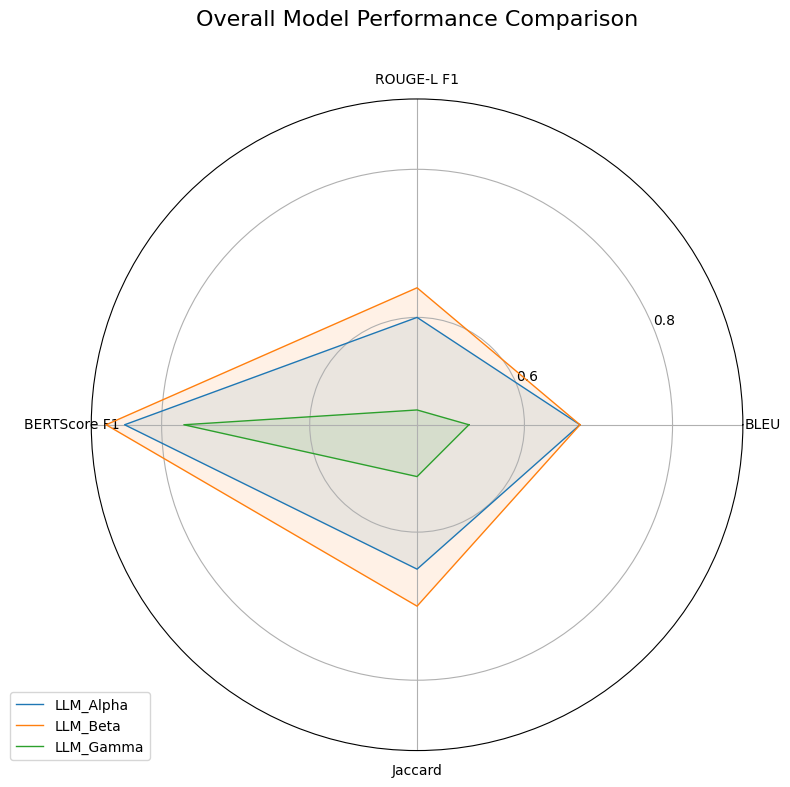

In [17]:
if results_df is not None:
    try:
        # Ensure matplotlib and numpy are available
        if plt is None:
            raise ImportError("Matplotlib is required for plotting but not installed.")
        if np is None:  # np.mean is default aggregate_func
            raise ImportError(
                "Numpy is required for default aggregation in plots but not installed."
            )

        # Select which metrics to include in the radar plot
        # These names must match the values in the 'metric_name' column of results_df
        metrics_for_radar = ["BLEU", "ROUGE-L F1", "BERTScore F1", "Jaccard"]

        print("\nGenerating radar plot for model comparison...")
        plt.figure(figsize=(8, 8))  # Create a figure for the plot
        ax_radar = plot_radar_comparison(
            results_df,
            metrics=metrics_for_radar,  # List of metrics to include
            # aggregate_func=np.mean, # np.mean is the default
            title="Overall Model Performance Comparison",
        )
        plt.show()
    except ImportError as e:
        print(f"Skipping radar plot visualization due to missing dependency: {e}")
    except (
        ValueError
    ) as e:  # plot_radar_comparison can raise ValueError for invalid metric lists etc.
        print(f"Skipping radar plot due to a configuration error: {e}")
    except Exception as e:
        print(f"An error occurred during radar plot generation: {e}")
else:
    print("Skipping radar plot visualization as results_df was not created or an error occurred.")